# Alberi di classificazione / Regressione (CART)

* Gli alberi sono un ottimo metodo di ML per capire e spiegare.
* Simulano il processo decisionale umano.
* Sono un metodo parametrico (perchè produce un modello, che è l'albero, visualizzabile anche con *p* alto) e non-lineare (nella struttura delle regioni create dal decision boundary).
* Creano oggetti strutturati (Wikipedia EN).
* Non richiedono (necessariamente) la standardizzazione (a differenza del knn) perchè NON fanno uso del concetto di distanza.

In [15]:


from IPython.display import Image               # per importare in una cella di tipo CODICE un'immagine 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


import matplotlib
from distutils.version import LooseVersion       # To check recent matplotlib compatibility
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from dmba import classificationSummary
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from dmba import regressionSummary

L'albero simula un tipico processo decisionale, ad esempio di un medico durante una visita.

![](images_cart/cart_example.png)

### L'Information Gain 

L'albero cerca di costruire delle **regioni omogenee**; si pone dunque il problema di disporre di una **metrica** che appunto misuri quanto un dato dataset (quello iniziale oppure uno intermedio, cioè già frutto di alcuni split, oppure ancora la foglia finale) è omogeneo ("puro") oppure disomogeneo ("impuro").

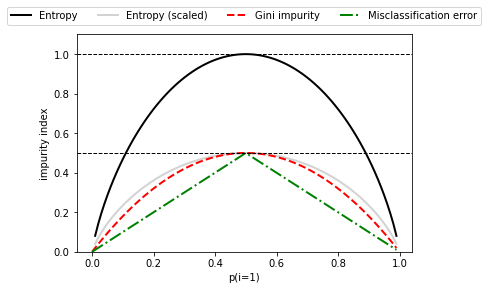

In [16]:
# plot di PML (p.96)
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')

plt.rcParams["figure.figsize"] = (10,8)

plt.show()
                                        # --> la p sono stimate in base alle frequenze campionarie

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi


[Una figura simile con anche i dataset](images_cart/dsfb_0303.png)

### Preparazione dei mattoni: dataset (iris) e funzione di plot del DB 

In [17]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()        
      
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y)) # The classes are already converted to integer labels where 0=Iris-Setosa, 
                                     # 1=Iris-Versicolor, 2=Iris-Virginica. (PML notebook)

Class labels: [0 1 2]


In [18]:
# i datatype di X e y sono di 'numpy'
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<AxesSubplot:xlabel='petal length', ylabel='petal width'>

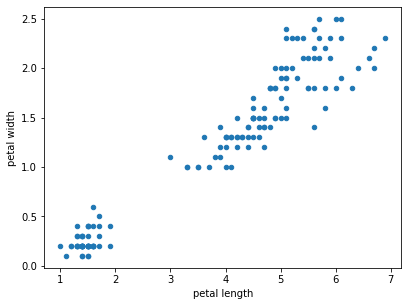

In [19]:
# volendo lo scatterplot delle due colonne di X, senza uso di matplotlib, si può fare così [per lo scatterplot CON
# matplotlib, vedi più avanti]:
import pandas as pd
df = pd.DataFrame(data= X,columns= ['petal length','petal width']) # conversione ad un df pandas (vedi nb giornata 2)
df
df.plot.scatter(x=0,y=1) # le colonne (per l'asse x e l'asse y) sono indicate con l'indice (anzichè il nome colonna)                

In [20]:
# proseguendo con X e y (due nd-array di numpy), ora lo split:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y) # 'stratify=y' --> "data is split in a stratified fashion, using this as
                                                     #  the class labels.

In [21]:
print('Labels count in y:', np.bincount(y))
print('Labels count in y_train:', np.bincount(y_train))
print('Labels count in y_test:', np.bincount(y_test))

Labels count in y: [50 50 50]
Labels count in y_train: [35 35 35]
Labels count in y_test: [15 15 15]


In [22]:
# la standardizzazione NON è necessaria con gli alberi, anche se può essere utile per la visualizzazione (PML, p. 96)

In [23]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [24]:
# la funzione di plot del DB (generale) per dati di training e test (BIVARIATI) 
# [da Python Machine Learning, p. 58 - seconda versione della funzione, che evidenzia anche le osservazioni del test set
# con un piccolo cerchio, tramite il nuovo argomento 'test_idx'].

# nei precedenti notebook erano stati forniti anche dei codici alternativi (per questa funzionalità).

# le funzioni 'numpy.vstack' e 'numpy.hstack' concatenano per riga o colonna (vedi help).
# --> classifier.predict grazie alla consistenza semantica della estimator API di scikit-learn!

# da p. 35 di PML:
# "Si definisce un insieme di colori e di marker e si crea una mappa-colori con 'ListedColormap'.
# Poi si determinano i valori minimo e massimo delle due feature e si crea tramite essi una coppia di grid array, xx1 
# xx2, con la funzione di numpy 'meshgrid'. 
# La funzione numpy 'ravel' restituisce una "contiguous flattened array".
# Quindi si fa reshaping delle label previste in una griglia con le stesse dimensioni di xx1 e xx2, e quindi si disegna un
# contour plot con la funzione matplotlib 'contour', che mappa le varie decision regions in colori differenti per ogni 
# classe prevista nella grid array.
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    plt.figure(figsize=(12,10))
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')        

In [13]:
# la versione del cap. 2 (meno sofisticata):
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

### Il plot del DB

Gli alberi possono costruire DB complessi dividendo lo spazio dei predittori/feature in regioni rettangolari.<br>
Occorre comunque fare attenzione, poichè, più *profondo* è l'albero (cioè, maggiore è il suo numero di livelli), più complessi sono i DB risultanti e maggiore è il<br>
rischio di overfitting.<br>
Useremo in questo esempio una profondità massima dell'albero di 4 (livelli) e l'indice di Gini come misura dell'impurità.<br>


In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini',   # il solito metodo "costruttore"
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))  # riunisco il dataset (predittori)
y_combined = np.hstack((y_train, y_test))  # riunisco il dataset (risposte)
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,  # la funzione è general-purpose, funziona per differenti classificatori
                      test_idx=range(105, 150)) # per la versione di 'plot_decision_regions' del cap. 3 
                      # (non usare con la versione del cap. 2)
# plt.figure(figsize=(10,8))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()


TypeError: plot_decision_regions() got an unexpected keyword argument 'test_idx'

In [ ]:
# L'albero ha separato molto bene le tre classi! L'unico errore visibile (nel test set) è di una osservazione di classe 2 
# prevista di classe 1. Per il training set, ci sono anche due osservazioni di classe 1 assegnate alla classe 2.

In [ ]:
# Si può tornare provare con un altro valore di max_depth (nel metodo costruttore) e vedere cosa succede (esercizio).

### La matrice di confusione e l'accuratezza

In [18]:
# qual è l'accuratezza?
# servono alcune funzioni numpy:
# - np.sum           la somma di tutti gli elementi dell'array
# - array.trace()    la traccia dell'array, cioè la somma degli elementi della diagonale principale
# - la lunghezza dell'array? vedi so 187455 per questo code snippet:
#   size = 1
#   for dim in np.shape(cm): size *= dim
#   size
cm = confusion_matrix(y_test, tree_model.predict(X_test))
print(cm)
print(cm.trace()/np.sum(cm))

[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]
0.9777777777777777


## L'output
Molti modi per visualizzare l'albero prodotto.<br>

### *plot_tree*
Un utile metodo di *sklearn.tree* permette di visualizzare l'albero prodotto dal learning.<br>
[Da questo sito:](https://mljar.com/blog/visualize-decision-tree/) "The **plot_tree** method was added to sklearn in version **0.21**. It requires **matplotlib** to be installed [e non graphviz, ndr].<br> It allows us to easily produce figure of the tree (without intermediate exporting to **graphviz**) The more information about 'plot_tree' arguments are in the docs."

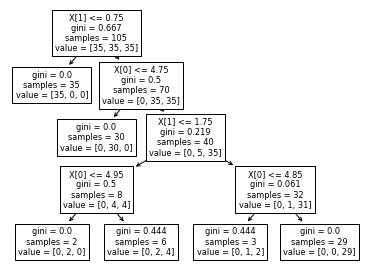

In [16]:
from sklearn import tree
tree.plot_tree(tree_model)
plt.show()

NB. Tutte le visualizzazioni di albero disponibili in scikit-learn, a mia conoscenza, visualizzano come prima riga del nodo lo
split ad esso DOPO applicato. Ciò può risultare **fuorviante**. <br>
Ogni box, a partire dal primo, che si riferisce alla radice e contiene tutti i dati del dataset (di training), descrive il nodo in termini di numero di osservazioni (o percentuali), misura di impurità, valori di classe ed eventualmente (se richiesta) la previsione.<br> A valle di ciò, o meglio in base a ciò, il metodo sceglie di applicare uno split/valore, che è visualizzato però nella prima riga, anzichè, come forse risulterebbe più chiaro, nell'ultima riga del box.

In [ ]:
# per ingrandire/reimpostare le dimensioni della figura del plot?
# dall'help di 'tree.plot_tree':
#    The visualization is fit automatically to the size of the axis.
#    Use the ``figsize`` or ``dpi`` arguments of ``plt.figure``  to control
#    the size of the rendering.
# vedi anche so 332289 e 38666527
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,10)
tree.plot_tree(tree_model)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi


In [ ]:
# solo 2 livelli (max_depth=2) - come visualizzazione qui, NON come produzione (nel costruttore)
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)
tree.plot_tree(tree_model,max_depth=2)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi


In [ ]:
# versione colorata (con l'argomento 'filled=True')
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)
tree.plot_tree(tree_model,filled=True)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi


*filled* : bool, default=False<br>
    When set to ``True``, it paints nodes to indicate majority class for<br>
    classification, extremity of values for regression, or **purity of node<br>
    for multi-output**.<br>
Quindi: 
* un'unica regione pura classifica setosa (in marrone);
* due regioni classificano versicolor (stesso verde perchè entrambe pure);
* quattro regioni classificano virginica (intensità del viola differenti a seconda della purezza.

In [ ]:
# versione con, per ogni box, i nomi delle feature (prima riga) e delle classi previste (ultima riga).
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,12)
tree.plot_tree(tree_model,
               feature_names=iris.feature_names,  
               class_names=iris.target_names,
               filled=True)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi


In [ ]:
# versione con le percentuali per nodo (anzichè il numero di osservazioni)
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,12)
tree.plot_tree(tree_model,proportion=True,
               feature_names=iris.feature_names,  
               class_names=iris.target_names,
               filled=True)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi


In [ ]:
# versione con i box arrotondati ed il font helvetica
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,12)
tree.plot_tree(tree_model,proportion=True,rounded=True,
               feature_names=iris.feature_names,  
               class_names=iris.target_names,
               filled=True)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi


In [ ]:
# una sintassi alternativa (senza 'plt.show()'):
from sklearn import tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
_ = tree.plot_tree(tree_model,proportion=True,             # '_ = ' toglie le fastidiose notazioni iniziali
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)
# plt.show()

In [ ]:
# Commenti all'albero prima visualizzato (vedi anche so 23557545):
# - Il metodo è partito da una radice con il dataset di training (105 obs. equamente ripartite nelle tre classi) che aveva
#   un valore dell'indice di Gini di 0.66. La previsione 'setosa' è arbitraria (la prima).
# - Il metodo ha scelto uno split di 'sepal width' con un valore di split = 0.75 cm.
# - Il nodo figlio di sx è risultato "puro" (indice di Gini = 0) con osservazioni solo di 'setosa' e dunque previsione 'setosa'.
#   E' un nodo terminale (anche detto foglia).
# - Il nodo figlio di dx è risultato equamente bipartito sulle due classi 'versicolors' e 'virginica' (Gini=0.5) ed ha richiesto
#   una serie di ulteriori split per separarle, a cominciare da 'petal lenght' <= 4.75.

# Come da noi impostato, l'albero ha (al massimo) 4 livelli.
# E con 3?
# Si può re-impostare 'max_depth'. 

In [ ]:
# se si vuole salvare l'albero su file png
fig.savefig("decision_tree.png")

### Rappresentazione testuale (set delle regole)

In [ ]:
text_representation = tree.export_text(tree_model,feature_names=iris.feature_names[:2])  # https://mljar.com/blog/visualize-decision-tree/
print(text_representation)

In [ ]:
# se si vuole salvarlo:
with open("decision_tree.log", "w") as fout:
    fout.write(text_representation)

### graphviz
Prima della versione 0.21 di scikit-learn era l'unico modo per avere un albero graficamente di buona qualità.

In [ ]:
# Per visualizzare l'albero, si può anche usare il software Graphviz (specializzato in questo), che può essere scaricato in modo gratuito dal sito 'http://grapviz.org' ed è disponibile per Win10, Linux e macOS.

[Il sito di Graphviz](http://www.graphviz.org)

In [ ]:
# In aggiunta, installiamo la libreria python 'PyDotPlus' (per interagire da python con Graphviz): 

![](pydotplus.png)

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_model,
                           filled=True,                      # aggiunge i colori
                           rounded=True,                     # arrotonda i bordi dei box
                           class_names=['Setosa',            # mostra il nome della classe maggioritaria per ogni nodo
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length',    # visualizza il nome della feature di ogni split (con il cut-off)
                                          'petal width'],
                           out_file=None)                    # assegna direttamente i DOT data ad una variable dot_data
                                                             # anzichè scrivere un file intermedio tree.dot sul disco
graph = graph_from_dot_data(dot_data) 

graph.write_png("tree.png")                                  # --> problema con l'encoding dello standard error? (in Windows!)
                                                             #     su Linux o macOS non dovrebbero esserci problemi.

In [ ]:
# PROVE MIE (relative all'errore finale della cella precedente) - NON è codice PML o DMforBA
# vedi anche email di Peter Gedeck del 31.5.21.

# from so 55738377
import os as os
os.environ['PYTHONIOENCODING'] = 'utf-8'

import sys
print(sys.stderr.encoding)

import sys
sys.path.append('C:/Users/W 10 Pro/anaconda3/Library/bin/graphviz/')

# sys.stdin.reconfigure(encoding="utf-8")
# sys.stdout.reconfigure(encoding="utf-8")
# sys.stderr.reconfigure(encoding="utf-8")

### *dtreeviz* Package
The dtreeviz package is available in github. It can be installed with <u>pip install dtreeviz</u>. It requires graphviz to be installed (but you dont need to manually convert between DOT files and images). 

In [ ]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(tree_model, X, y,label_fontsize=12,ticks_fontsize=8,scale=1.4, # 'scale' (1.0 il default) scales the width, 
                                                                              # height of the overall SVG preserving aspect 
                                                                              # ratio.
                target_name="target",
                feature_names=iris.feature_names,
                class_names=list(iris.target_names))

viz

## Alberi vs modelli lineari

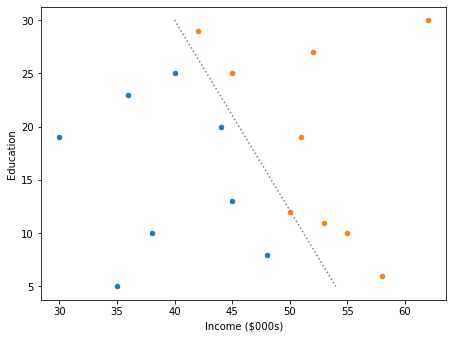

In [23]:
# Un dataset (costruito ad hoc) con due predittori e due classi, nel quale la separazione tra le due classi è chiaramente meglio 
# realizzata da una linea diagonale. Un albero di classificazione qui fornirà un alto error-rate, probabilmente. (DMforBA, p. 247)

import pandas as pd
import matplotlib.pyplot as plt
fakeScatter = pd.DataFrame([
    (30, 19, 1), (35, 5, 1), (40, 25, 1), (45, 13, 1), 
    (38, 10, 1), (36, 23, 1), (48, 8, 1), (44, 20, 1), (50, 12,0),
    (51, 19, 0), (62, 30, 0), (42, 29, 0), (45, 25, 0), 
    (55, 10, 0), (52, 27, 0), (58, 6, 0), (53, 11, 0), 
], columns=['x1', 'x2', 'category'])
ax = fakeScatter.loc[fakeScatter.category==1,:].plot.scatter(x='x1', y='x2', color='C0')
fakeScatter.loc[fakeScatter.category==0,:].plot.scatter(x='x1', y='x2', ax=ax, color='C1')
plt.plot((40, 54), (30, 5), ':', color='grey')  # il separatore (DB) costruito a mano (con le  coordinate dei due punti 
                                                # estremi della retta, espresse in questo modo: le ascisse dei due estremi 
                                                # della retta, le ordinate dei due estremi della retta)
ax.set_xlabel('Income ($000s)')
ax.set_ylabel('Education')

plt.tight_layout()
plt.show()

In [24]:
fakeScatter

,x1,x2,category
0,30,19,1
1,35,5,1
2,40,25,1
3,45,13,1
4,38,10,1
5,36,23,1
6,48,8,1
7,44,20,1
8,50,12,0
9,51,19,0


In [21]:
fakeScatter.shape

(17, 3)

In [25]:
# creiamo la solita matrice X ed il solito vettore y:
X = fakeScatter.drop(columns=['category'])
y = fakeScatter['category']
print(X.values)
print
print(y.values)

[[30 19]
 [35  5]
 [40 25]
 [45 13]
 [38 10]
 [36 23]
 [48  8]
 [44 20]
 [50 12]
 [51 19]
 [62 30]
 [42 29]
 [45 25]
 [55 10]
 [52 27]
 [58  6]
 [53 11]]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]


In [26]:
# costruzione del fit lineare (con SVM)
from sklearn.svm import SVC
svc = SVC(C=1, kernel='linear')
svc.fit(X, y)

SVC(C=1, kernel='linear')

In [27]:
# un'occhiata agli output:
print('C: ',svc.C)                
print('weight: ',svc.class_weight_)                            
print('classi: ',svc.classes_)         
print('stato: ',svc.fit_status_)      
print('indici vettori suppporto',svc.support_)         
print('vettori supporto: ','\n',svc.support_vectors_) 
print('num vett. supp. per classe: ',svc.n_support_) 

C:  1
weight:  [1. 1.]
classi:  [0 1]
stato:  0
indici vettori suppporto [ 8 11  7]
vettori supporto:  
 [[50. 12.]
 [42. 29.]
 [44. 20.]]
num vett. supp. per classe:  [2 1]


In [28]:
# le pseudo previsioni e la CM:
y_pred = svc.predict(X)
pd.DataFrame(confusion_matrix(y, y_pred), index=svc.classes_, columns=svc.classes_)

,0,1
0,9,0
1,0,8


In [32]:
X_new = pd.DataFrame([
    (40,20)
], columns=['x1', 'x2'])

In [36]:
svc.predict_proba(X_new)

AttributeError: predict_proba is not available when  probability=False

In [38]:
# costruzione del fit non-lineare (con un albero):
clf = DecisionTreeClassifier(random_state=1) 
clf.fit(X,y)
y_pred = clf.predict(X)
pd.DataFrame(confusion_matrix(y, y_pred), index=clf.classes_, columns=clf.classes_)

                            # --> uguali, come mai?

,0,1
0,9,0
1,0,8


## Ulteriori esempi di classificazione 

### riding_mowers (taglia-erba)
Un'azienda che produce taglia-erba vuole identificare i clienti *best prospects* per la prossima campagna di marketing.<br>
In particolare, l'azienda è interessata a classificare i clienti (famiglie) come best prospect (oppure no) in base al loro reddito annuale (in $1000) e dimensione del prato (in 1000 ft^2).<br>
L'esperto di marketing ha fornito un campione di 24 famiglie.<br>
Con il datatset 'riding_mowers' costruiremo l'albero sul dataset **completo** per vedere che split trova. Non applichiamo la separazione tra training e test set, per questo esempio.

In [8]:
from sklearn.tree import DecisionTreeClassifier
mower_df = pd.read_csv('data_cart/RidingMowers.csv')
classTree = DecisionTreeClassifier(random_state=0, max_depth=1)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
print("Classes: {}".format(', '.join(classTree.classes_)))
mower_df.columns[:2]

Classes: Nonowner, Owner


Index(['Income', 'Lot_Size'], dtype='object')

In [9]:
mower_df

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner
5,110.1,19.2,Owner
6,108.0,17.6,Owner
7,82.8,22.4,Owner
8,69.0,20.0,Owner
9,93.0,20.8,Owner


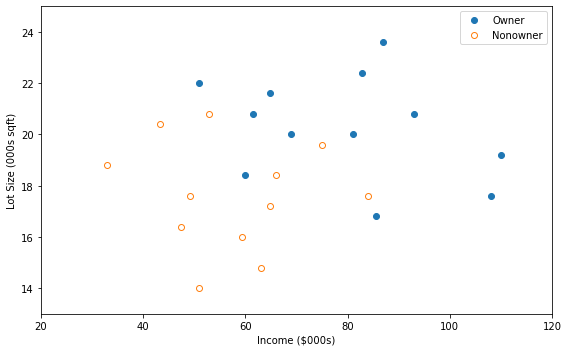

In [10]:
# scatterplot (con matplotlib) dei due predittori quantitativi (Income e Lot_Size) 

def basePlot(ax):
    mower_df.loc[mower_df.Ownership=='Owner'].plot(x='Income', y='Lot_Size', style='o', 
                                                   markerfacecolor='C0', markeredgecolor='C0',
                                                   ax=ax)
    mower_df.loc[mower_df.Ownership=='Nonowner'].plot(x='Income', y='Lot_Size', style='o',
                                                      markerfacecolor='none', markeredgecolor='C1',
                                                      ax=ax)
    ax.legend(["Owner", "Nonowner"]);
    ax.set_xlim(20, 120)
    ax.set_ylim(13, 25)
    ax.set_xlabel('Income ($000s)')
    ax.set_ylabel('Lot Size (000s sqft)')
    return ax

fig, ax = plt.subplots(figsize=(8, 5))

ax = basePlot(ax)
plt.tight_layout()
plt.show()

In [11]:
# drop utile dopo per costruire il classificatore (perchè occorrerà separare X e y)
mower_df.drop(columns=['Ownership']) # per eliminare una colonna (senza persistenza)
# --> questo metodo NON serve a togliere i Missing values!

,Income,Lot_Size
0,60.0,18.4
1,85.5,16.8
2,64.8,21.6
3,61.5,20.8
4,87.0,23.6
5,110.1,19.2
6,108.0,17.6
7,82.8,22.4
8,69.0,20.0
9,93.0,20.8


In [12]:
mower_df['Ownership'] # la terza colonna (estratta separatamente) - sarà la y per il classificatore

0        Owner
1        Owner
2        Owner
3        Owner
4        Owner
5        Owner
6        Owner
7        Owner
8        Owner
9        Owner
10       Owner
11       Owner
12    Nonowner
13    Nonowner
14    Nonowner
15    Nonowner
16    Nonowner
17    Nonowner
18    Nonowner
19    Nonowner
20    Nonowner
21    Nonowner
22    Nonowner
23    Nonowner
Name: Ownership, dtype: object

In [13]:
# la costruzione dell'albero con 1 livello solo (utilizzando il drop visto prima (rieseguito!)):
X = mower_df.drop(columns=['Ownership'])
y = mower_df['Ownership']
classTree = DecisionTreeClassifier(random_state=0, max_depth=1)
classTree.fit(X, y) # occorre appunto specificare X e y separatamente

DecisionTreeClassifier(max_depth=1, random_state=0)

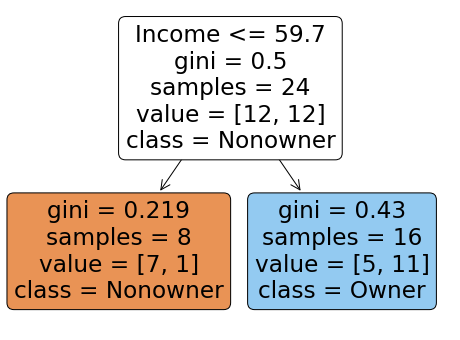

In [14]:
# plot dell'albero:
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
tree.plot_tree(classTree,rounded=True,
               feature_names=mower_df.columns[:2],  
               class_names=classTree.classes_,
               filled=True)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi

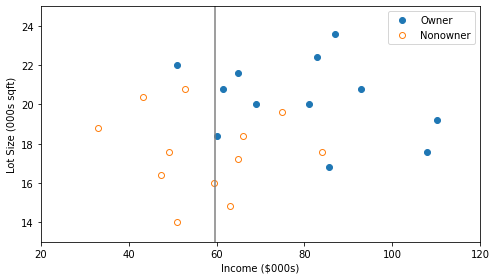

In [15]:
# lo scatterplot con la separazione in base allo split point scoperto prima dall'albero (costruito manualmente): 
fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
x0 = 59.7
ax.plot((x0, x0), (25, 13), color='grey')
plt.tight_layout()
plt.show()

# Il rettangolo di sx contiene quasi solo non-owners; quello di dx contiene soprattutto owners.
# Una separazione buona ma non ottima.

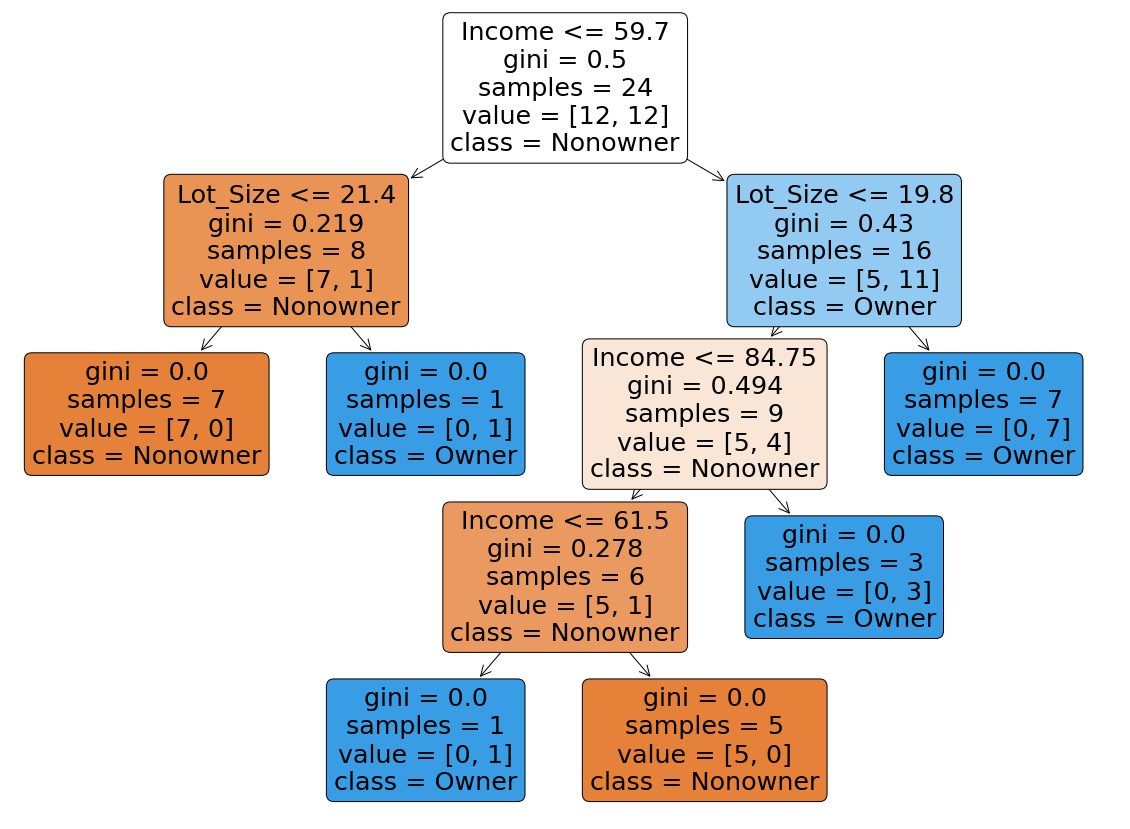

In [29]:
# la costruzione dell'albero senza impostare 'max_depth' ed il plot dell'albero risultante:
classTree = DecisionTreeClassifier(random_state=0) # non imposto la massima profondità
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership']) 

# plot dell'albero:
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
tree.plot_tree(classTree,rounded=True,
               feature_names=mower_df.columns[:2],  
               class_names=classTree.classes_,
               filled=True)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi

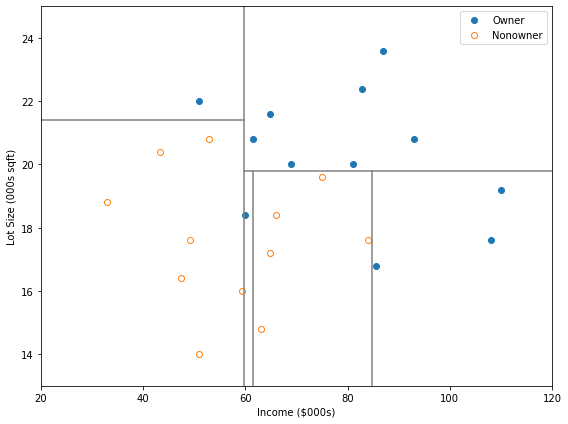

In [25]:
# lo scatterplot (sempre costruito manualmente) con la separazione in base agli split point scoperti prima dall'albero: 

fig, ax = plt.subplots(figsize=(8,6))

ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
y2 = 19.8
x3 = 84.75
x4 = 61.5
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
ax.plot((x0, 120), (y2, y2), color='grey')
ax.plot((x3, x3), (13, y2), color='grey')
ax.plot((x4, x4), (13, y2), color='grey')
plt.tight_layout()
plt.show()

# lo stato finale del partizionamento: ogni nodo terminale (regione) è puro.
# Ha creato 4 livelli.
# max_depth = 5 non produce quindi ulteriori split (provare).

In [33]:
# La matrice di confusione (sui dati di training):
from sklearn.metrics import confusion_matrix                # serve questa funzione di scikit-learn (anzichè quella del 
                                                            # package 'dmba')
cm = confusion_matrix(y, classTree.predict(X))
print()
print(cm)
print()
print(cm.trace()/np.sum(cm))
print()
print(classTree.predict(X))
print()
print(classTree.predict_proba(X))


[[12  0]
 [ 0 12]]

1.0

['Owner' 'Owner' 'Owner' 'Owner' 'Owner' 'Owner' 'Owner' 'Owner' 'Owner'
 'Owner' 'Owner' 'Owner' 'Nonowner' 'Nonowner' 'Nonowner' 'Nonowner'
 'Nonowner' 'Nonowner' 'Nonowner' 'Nonowner' 'Nonowner' 'Nonowner'
 'Nonowner' 'Nonowner']

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [34]:
# le previsioni per due nuove osservazioni (x in x4-x3, y in 0-y2).
# In questa regione ci sono solo non-owner (5).
import numpy as np
x0 = np.array([[70,15],[71,18]]) # costruzione di un'array 2-dim
print(classTree.predict(x0))
print(classTree.predict_proba(x0))

['Nonowner' 'Nonowner']
[[1. 0.]
 [1. 0.]]


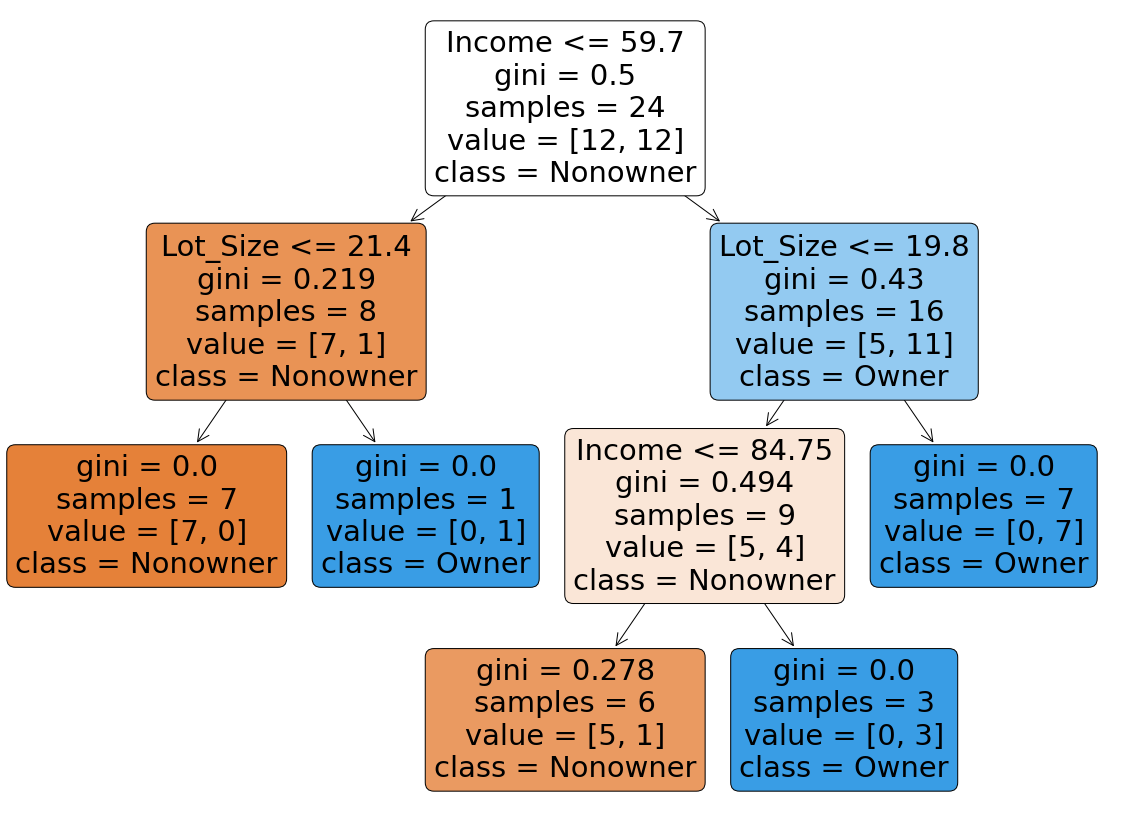

In [35]:
# la costruzione dell'albero con 'max_depth' = 3 ed il plot dell'albero risultante:
classTree = DecisionTreeClassifier(random_state=0,max_depth=3) 
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership']) 

# plot dell'albero:
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
tree.plot_tree(classTree,rounded=True,
               feature_names=mower_df.columns[:2],  
               class_names=classTree.classes_,
               filled=True)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi

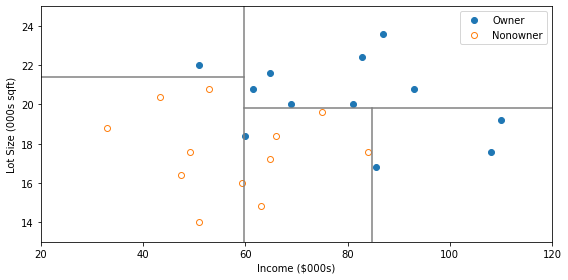

In [26]:
# lo scatterplot (sempre costruito manualmente) con la separazione in base agli split point scoperti prima dall'albero: 

fig, ax = plt.subplots(figsize=(8, 4))

ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
y2 = 19.8
x3 = 84.75
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
ax.plot((x0, 120), (y2, y2), color='grey')
ax.plot((x3, x3), (13, y2), color='grey')
plt.tight_layout()
plt.show()

# lo stato finale del partizionamento: ogni nodo terminale (regione) è puro.
# Ha creato 4 livelli.
# max_depth = 5 non produce quindi ulteriori split (provare).

In [36]:
# La matrice di confusione (sui dati di training):
from sklearn.metrics import confusion_matrix                # serve questa funzione di scikit-learn (anzichè quella del 
                                                            # package 'dmba')
cm = confusion_matrix(y, classTree.predict(X))
print()
print(cm)
print()
print(cm.trace()/np.sum(cm))
print()
print(classTree.predict(X))
print()
print(classTree.predict_proba(X))


[[12  0]
 [ 1 11]]

0.9583333333333334

['Nonowner' 'Owner' 'Owner' 'Owner' 'Owner' 'Owner' 'Owner' 'Owner'
 'Owner' 'Owner' 'Owner' 'Owner' 'Nonowner' 'Nonowner' 'Nonowner'
 'Nonowner' 'Nonowner' 'Nonowner' 'Nonowner' 'Nonowner' 'Nonowner'
 'Nonowner' 'Nonowner' 'Nonowner']

[[0.83333333 0.16666667]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.83333333 0.16666667]
 [1.         0.        ]
 [0.83333333 0.16666667]
 [1.         0.        ]
 [0.83333333 0.16666667]
 [1.         0.        ]
 [1.         0.        ]
 [0.83333333 0.16666667]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.83333333 0.16666667]]


### breast cancer
Valutazione delle prestazioni.<br>
Descrizione del dataset è [qui](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download).


In [39]:
from sklearn import datasets
import numpy as np

bc = datasets.load_breast_cancer()  

X = bc.data
y = bc.target

print('Class labels:', np.unique(y)) # The classes are already converted to integer labels 
list(bc.target_names)

Class labels: [0 1]


['malignant', 'benign']

In [40]:
X.shape

(569, 30)

In [41]:
print(X)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


In [42]:
# split dataset
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

clf = DecisionTreeClassifier(random_state=1) # l'albero pieno (senza pruning) costruito sul training set
clf.fit(train_X, train_y)

DecisionTreeClassifier(random_state=1)

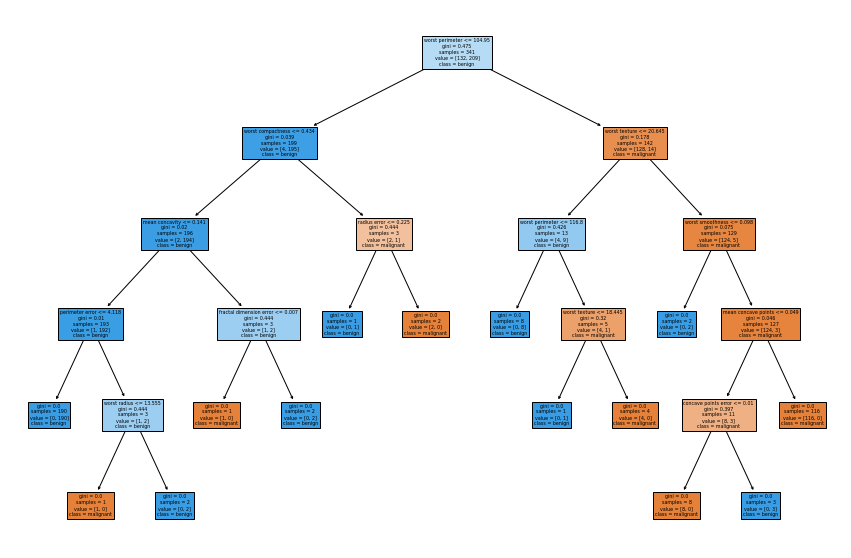

In [43]:
# plot dell'albero
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(clf, 
                   feature_names=bc.feature_names,  
                   class_names=bc.target_names,
                   filled=True)

In [44]:
text_representation = tree.export_text(clf)  # https://mljar.com/blog/visualize-decision-tree/
print(text_representation)

|--- feature_22 <= 104.95
|   |--- feature_25 <= 0.43
|   |   |--- feature_6 <= 0.14
|   |   |   |--- feature_12 <= 4.12
|   |   |   |   |--- class: 1
|   |   |   |--- feature_12 >  4.12
|   |   |   |   |--- feature_20 <= 13.55
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_20 >  13.55
|   |   |   |   |   |--- class: 1
|   |   |--- feature_6 >  0.14
|   |   |   |--- feature_19 <= 0.01
|   |   |   |   |--- class: 0
|   |   |   |--- feature_19 >  0.01
|   |   |   |   |--- class: 1
|   |--- feature_25 >  0.43
|   |   |--- feature_10 <= 0.22
|   |   |   |--- class: 1
|   |   |--- feature_10 >  0.22
|   |   |   |--- class: 0
|--- feature_22 >  104.95
|   |--- feature_21 <= 20.65
|   |   |--- feature_22 <= 116.80
|   |   |   |--- class: 1
|   |   |--- feature_22 >  116.80
|   |   |   |--- feature_21 <= 18.44
|   |   |   |   |--- class: 1
|   |   |   |--- feature_21 >  18.44
|   |   |   |   |--- class: 0
|   |--- feature_21 >  20.65
|   |   |--- feature_24 <= 0.10
|   |   |   

In [45]:
# valutazione delle prestazioni (training e test error-rate) con funzioni di scikit-learn:
from sklearn.metrics import confusion_matrix,accuracy_score

confusionMatrix = confusion_matrix(train_y,clf.predict(train_X)) # sul training set:
                                                                 # y vere vs y previste (pseudo-previsioni)
print(confusionMatrix)

accuracy = accuracy_score(train_y,clf.predict(train_X))
print(accuracy)

confusionMatrix = confusion_matrix(valid_y,clf.predict(valid_X)) # sul validation (test) set:
                                                                 # y vere vs y previste
print(confusionMatrix)

accuracy = accuracy_score(valid_y,clf.predict(valid_X))
print(accuracy)

[[132   0]
 [  0 209]]
1.0
[[ 68  12]
 [  8 140]]
0.9122807017543859


In [46]:
# qual è l'accuratezza del test?
confusionMatrix.trace()/np.sum(confusionMatrix)

0.9122807017543859

In [48]:
# meglio formattato (con una funzione di 'dmba')
from dmba import classificationSummary
classificationSummary(train_y, clf.predict(train_X))
classificationSummary(valid_y, clf.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 132   0
     1   0 209
Confusion Matrix (Accuracy 0.9123)

       Prediction
Actual   0   1
     0  68  12
     1   8 140


In [49]:
# k-fold CV error-rate (su tutto il dataset - preferibile)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf,X,y,cv=5)                 # score è un'altra metrica di accuratezza
                                                       # calcolata per ogni iterazione da questa
                                                       # classe. Per maggiori info:
                                                       # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
print(scores)
import numpy as np
print(round(np.mean(scores),2))                        # CV error rate (di TEST)

[0.90350877 0.90350877 0.92105263 0.94736842 0.91150442]
0.92


In [58]:
# cerchiamo di evitare l'overfitting costruendo un albero meno "bushy" (ramificato, cespuglioso):
clf = DecisionTreeClassifier(random_state=1,min_samples_leaf=8) # anzichè 'min_sample_leaf = 2' (il default);
                                                                # 'min_sample_leaf' è "the minimum number of samples required 
                                                                # to split an internal node".

from sklearn.model_selection import cross_val_score             # GridSearchCV implements a “score” method. 
scores = cross_val_score(clf,X,y,cv=5)
print('score: ',scores)
import numpy as np
print('score medio: ',round(np.mean(scores),2))                 # CV error rate
                                                                # --> miglioramento del 2%. come mai?
                                                                # l'albero precedente, con min_samples_leaf = default (2)
                                                                # andava in overfitting.  

score:  [0.92982456 0.9122807  0.95614035 0.96491228 0.92920354]
score medio:  0.94


Il valore del parametro è stato trovato con prove **manuali** (per un solo parametro di tuning: 'min_sample_leaf').<br>
Ci vuole tempo con molti parametri!

In [62]:
# utilizziamo la GRID SEARCH automatica (sul TRAINING set), in questo modo (2 passi):

from sklearn.model_selection import GridSearchCV

# step a) Start with an initial guess for parameters (i tre parametri di tuning degli alberi, ndr)
param_grid = {
    'max_depth': [1, 2, 3, 4], 
    'min_samples_split': [5,8,10,20,50], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1,)
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)          # è, come sempre, una MEDIA sulle
                                                          # iterazioni della CV
    
print('Initial parameters: ', gridSearch.best_params_)    # i parametri (gli split e gli split
                                                          # point del miglior modello tra i 100
                                                          # provati.

# è una ricerca ESAUSTIVA sulle combinazioni di parametri (DMforBA - python vers., p. 234).
# qui abbiamo 4x5x5=100 combinazioni --> 100 modelli!
# se sono troppe, si può usare la 'RandomizedSearchCV'.

# assunzione implicita: i parametri di tuning possono esssere dipendenti uno dall'altro, 
# ma non è detto. In questo secondo caso (indipendenti) l'approccio migliore è quello di
# testare un singolo parametro per volta.

# step b) Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(5,6,7)), 
    'min_samples_split': list(range(3,5,7)), 
    'min_impurity_decrease': [0.09,0.05,0.01,0.005,0.001], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

# --> non confondere la 'GridSearchCV', che è una tecnica di Model Selection sui parametri di tuning, con la potatura
#     (pruning) degli alberi, che è una tecnica di regolarizzazione, attuata a valle della costruzione dell'albero completo
#     (a meno di qualche limitato criterio di stop per prevenire l'overfitting ovvio), e che utilizza lo shrinkage (penalty)
#     per ridurre la varianza.

Initial score:  0.9473145780051151
Initial parameters:  {'max_depth': 4, 'min_impurity_decrease': 0.01, 'min_samples_split': 10}
Improved score:  0.9443734015345269
Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.01, 'min_samples_split': 3}


In [ ]:
# ora, usiamo quell'albero (con quei parametri ottimi) per la misurazione dell'errore
classificationSummary(train_y, bestClassTree.predict(train_X)) 
classificationSummary(valid_y, bestClassTree.predict(valid_X)) # misura più affidabile

## la potatura dell'albero
Sempre per semplificare un albero inutilmente complesso (ramificato), un'altra tecnica è quella di **potare** l'albero, e di vedere se le sue prestazioni predittive migliorano o peggiorano.<br>
Attenzione: spesso, l'albero potato ha prestazioni predittive NON migliori di quello originale, ma, in compenso, è più semplice, anche da illustrare. A volte, quindi, si accetta persino di pagare un piccolo prezzo (errore di test un pò maggiore) per avere un albero molto più semplice.<br>
[spiegazione del ccp in scikit-learn](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)<br>
[altro post sul ccp](https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/)

### l'esempio di scikit-learn (su breast cancer)

In [63]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

In [64]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# ccp_alphas: Effective alphas of subtree during pruning.
# Impurities: Sum of the impurities of the subtree leaves for the corresponding alpha value in `ccp_alphas`.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

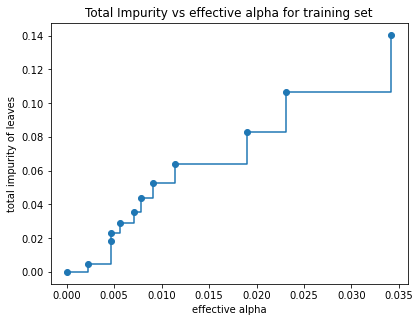

In [65]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# all'aumentare di alpha, aumenta la penalizzazione, e dunque aumenta la potatura, con conseguente maggiore impurità delle foglie.

In [66]:
# ora costruiamo una serie di alberi differentemente potati (tramite valori diversi di alfa).
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))  # 1 solo nodo, non lo consideriamo (troppo grezzo)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3272984419327777


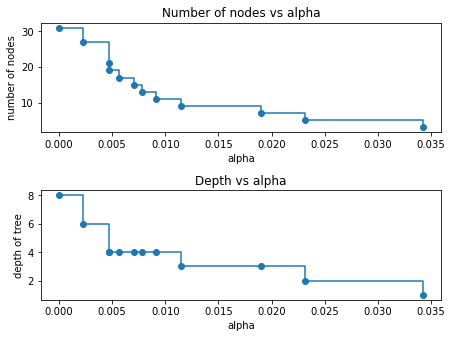

In [67]:
# Ora esaminiamo come il parametro alfa (il costo, la penalty per alberi troppo ramificati e
# che è inclusa nella funzione obiettivo da minimizzare) INFLUENZA sulla complessità dell'albero,ù
# valutata rispetto a due differenti criteri (non indipendenti): il numero di nodi ed il numero 
# di livelli dell'albero.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

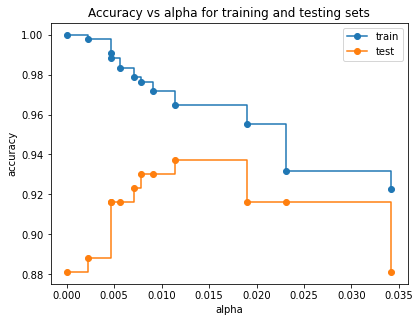

In [68]:
# ora, l'accuratezza:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

## Alberi di regressione

Molto simili. <br>
Differenze con alberi di classificazione:
* la previsione della regione è **average** (media, mediana, moda) delle osservazioni di training appartenenti a quella regione;
* misura di impurità: la varianza; più esattamente **Residual Sum of Squares**, cioè la somma degli scarti al quadrato delle y osservate con l'average della regione, che coincide con la somma degli errori di previsione al quadrato (poichè la media della regione è esattamente la previsione)
* le misure di valutazione: MSPE (od altre) anzichè l'error rate.

In [27]:
# import dei moduli necessari:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

[il dataset di kaggle](https://www.kaggle.com/tolgahancepel/toyota-corolla)

In [28]:
# caricamento dei dati:
toyotaCorolla_df = pd.read_csv('data_cart/ToyotaCorolla.csv').iloc[:1000,:]
toyotaCorolla_df = toyotaCorolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})
print(toyotaCorolla_df.shape)        # le dimensioni del dataset
# pd.set_option('display.width', 120)  # il reset del numero di caratteri per riga visualizzati prima di andare a capo (con \)
toyotaCorolla_df.head(5)             # la prima 5 righe

(1000, 39)


,Id,Model,Price,Age,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,1,0,0,0,1,0,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,0,1,0,1,0,0,0,0


In [29]:
# selezione di alcuni predittori (10) e della risposta
predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Tax', 'Weight']
toyotaCorolla_df[predictors]

,Age,KM,Fuel_Type,HP,Met_Color,Automatic,CC,Doors,Tax,Weight
0,23,46986,Diesel,90,1,0,2000,3,210,1165
1,23,72937,Diesel,90,1,0,2000,3,210,1165
2,24,41711,Diesel,90,1,0,2000,3,210,1165
3,26,48000,Diesel,90,0,0,2000,3,210,1165
4,30,38500,Diesel,90,0,0,2000,3,210,1170
...,...,...,...,...,...,...,...,...,...,...
995,68,42750,Petrol,110,1,0,1600,3,69,1050
996,67,42102,Petrol,110,1,0,1600,5,85,1075
997,63,41586,Petrol,110,1,0,1600,5,19,1114
998,64,41200,Petrol,110,0,0,1600,5,85,1070


In [30]:
# conversione dei predittori qualitativi (Fuel_Type) in dummy variable:
print(toyotaCorolla_df['Fuel_Type'].unique())                     # i valori distinti di 'Fuel_Type'
X = pd.get_dummies(toyotaCorolla_df[predictors], drop_first=True) # drop_first : bool, default False;
                                                                  # "whether to get k-1 dummies out of k categorical levels 
                                                                  # by removing the first level.

X[:10]     # le prime 10 righe --> vedi le DUE (=k-1) colonne 'Fuel_Type_*'.

['Diesel' 'Petrol' 'CNG']


,Age,KM,HP,Met_Color,Automatic,CC,Doors,Tax,Weight,Fuel_Type_Diesel,Fuel_Type_Petrol
0,23,46986,90,1,0,2000,3,210,1165,1,0
1,23,72937,90,1,0,2000,3,210,1165,1,0
2,24,41711,90,1,0,2000,3,210,1165,1,0
3,26,48000,90,0,0,2000,3,210,1165,1,0
4,30,38500,90,0,0,2000,3,210,1170,1,0
5,32,61000,90,0,0,2000,3,210,1170,1,0
6,27,94612,90,1,0,2000,3,210,1245,1,0
7,30,75889,90,1,0,2000,3,210,1245,1,0
8,27,19700,192,0,0,1800,3,100,1185,0,1
9,23,71138,69,0,0,1900,3,185,1105,1,0


In [31]:
X.shape # 11 predittori ora, poichè 'Fuel_Type' è stato diviso in due

(1000, 11)

In [32]:
# agggiornamento della lista dei predittori (11 anzichè 10)
predictors = ['Age', 'KM', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Tax', 'Weight','Fuel_Type_Diesel','Fuel_Type_Petrol']

In [33]:
# selezione della risposta
outcome = 'Price'
y = toyotaCorolla_df[outcome]
y[:1]     # il primo valore

0    13500
Name: Price, dtype: int64

In [34]:
# la suddivisione del dataset:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [35]:
# la griglia di ricerca sui parametri di tuning 
# [user grid search to find optimized tree]
# GridSearchCV: Exhaustive search over specified parameter values for an estimator.
# GridSearchCV fa solo Model Selection, non Model Assessment, perciò bisogna separare i dati in training e test set ed eseguirla
# sui dati di training.

param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'min_samples_split': [10, 20, 30, 40, 50], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial (best) parameters: ', gridSearch.best_params_) # 'best_params' è un metodo di GridSearchCV

# una seconda griglia più ampia [ci mette un attimo]:
param_grid = {
    'max_depth': [1,2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008], 
    'min_samples_split': [14, 15, 16, 18, 20,25,30,50], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_) # 'best_params' è un metodo di GridSearchCV

regTree = gridSearch.best_estimator_ # "Estimator that was chosen by the search, i.e. estimator which gave highest score 
                                     # (or smallest loss if specified) on the left out data." 

Initial (best) parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 20}
Improved parameters:  {'max_depth': 6, 'min_impurity_decrease': 0, 'min_samples_split': 16}


In [36]:
# le prestazioni predittive del 'best estimator' sul training set e sul validation set (qui chiamato 'validation') 
# con una funzione di 'dmba':
from dmba import regressionSummary
regressionSummary(train_y, regTree.predict(train_X))
regressionSummary(valid_y, regTree.predict(valid_X))
                               # 1. RMSE Test > RMSE Training
                               # 2. RMSE Albero (di test) > RMSE Regressione (di test), che era 1310 (vedi altro nb)


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1058.8202
            Mean Absolute Error (MAE) : 767.7203
          Mean Percentage Error (MPE) : -0.8074
Mean Absolute Percentage Error (MAPE) : 6.8325

Regression statistics

                      Mean Error (ME) : 60.5241
       Root Mean Squared Error (RMSE) : 1554.9146
            Mean Absolute Error (MAE) : 1026.3487
          Mean Percentage Error (MPE) : -1.3082
Mean Absolute Percentage Error (MAPE) : 9.2311


In [37]:
# le prestazioni predittive utilizzando solo la metrica di scoring interna alla CV di scikit-learn e con una 5-fold CV 
# sull'intero dataset:
# vedi: https://scikit-learn.org/stable/modules/model_evaluation.html
# --> an internal scoring strategy
from sklearn.model_selection import cross_val_score
print(cross_val_score(regTree,X, y, cv=5))
# non possiamo dunque confrontare questi valori con le metriche calcolate (in altro modo) da 'dmba'.

[-1.3572093  -0.13891543 -0.95607455  0.10240556 -1.98267747]


In [38]:
# la visualizzazione dell'albero ottenuto, ora (in vari modi, come prima per l'albero di classificazione)
text_representation = tree.export_text(regTree,feature_names=predictors)
print(text_representation)

|--- Age <= 31.50
|   |--- Weight <= 1127.50
|   |   |--- Age <= 12.50
|   |   |   |--- value: [18809.17]
|   |   |--- Age >  12.50
|   |   |   |--- HP <= 103.50
|   |   |   |   |--- Age <= 21.00
|   |   |   |   |   |--- value: [16580.67]
|   |   |   |   |--- Age >  21.00
|   |   |   |   |   |--- value: [15103.33]
|   |   |   |--- HP >  103.50
|   |   |   |   |--- KM <= 24329.50
|   |   |   |   |   |--- value: [18678.00]
|   |   |   |   |--- KM >  24329.50
|   |   |   |   |   |--- value: [16338.08]
|   |--- Weight >  1127.50
|   |   |--- Age <= 13.50
|   |   |   |--- value: [23768.46]
|   |   |--- Age >  13.50
|   |   |   |--- HP <= 151.00
|   |   |   |   |--- KM <= 38000.00
|   |   |   |   |   |--- Doors <= 4.50
|   |   |   |   |   |   |--- value: [21025.00]
|   |   |   |   |   |--- Doors >  4.50
|   |   |   |   |   |   |--- value: [18925.00]
|   |   |   |   |--- KM >  38000.00
|   |   |   |   |   |--- value: [17233.33]
|   |   |   |--- HP >  151.00
|   |   |   |   |--- value: [21760.

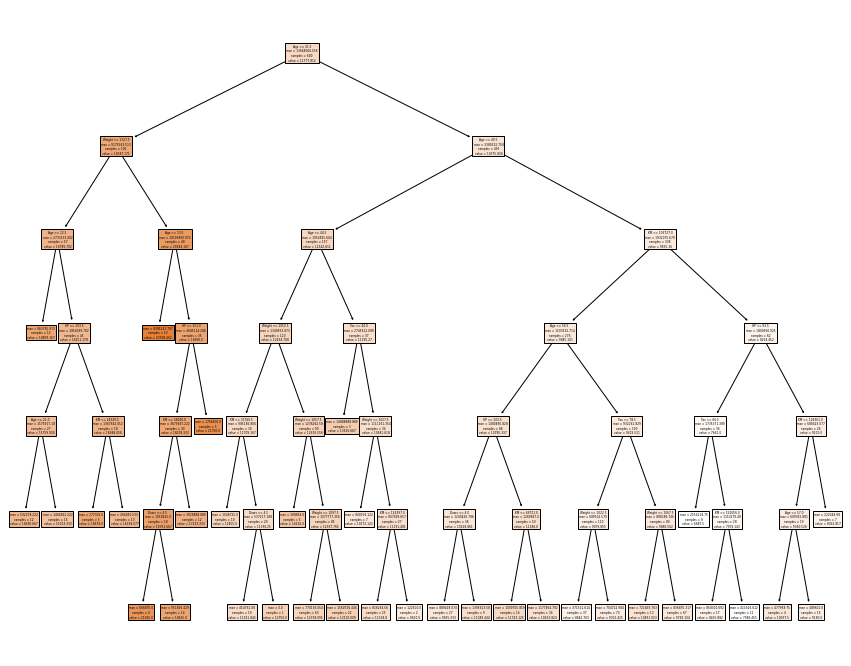

In [39]:
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,12)
tree.plot_tree(regTree,
               feature_names=predictors,  
               filled=True)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi

# ILLEGGIBILE con tutti i livelli (che sono 6, come miglior valore prima trovato nella griglia di ricerca!)

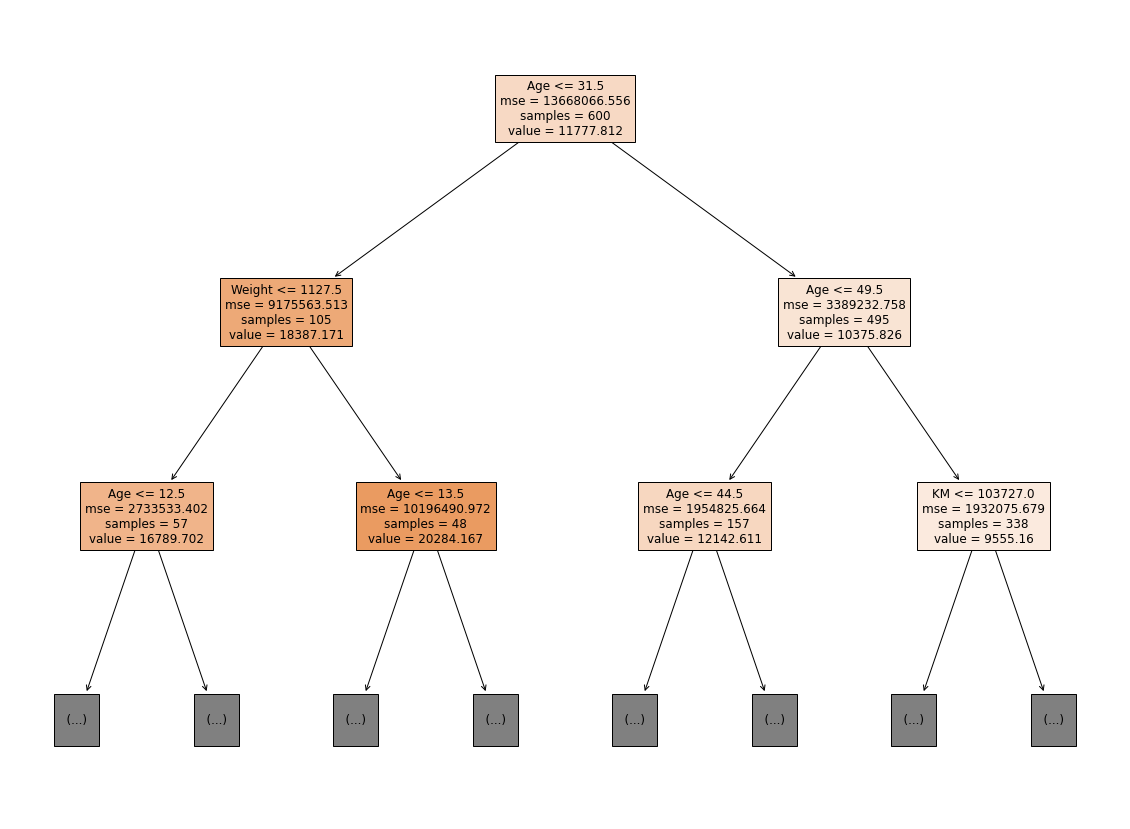

In [40]:
# limitiamo i livelli visualizzati
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
tree.plot_tree(regTree,max_depth=2,
               feature_names=predictors,  
               filled=True)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi

# Please notice, that the color of the leaf is coresponding to the predicted value.

# --> allo scendere di livello si ha che:
#     1. i valori di Y (prezzo) previsti si differenziano tra i vari nodi
#     2. i valori di Y (prezzo) previsti tendenzialmente di

In [ ]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(regTree, X, y,
                target_name="target",
                feature_names=predictors)
viz
# it shows the distribution of decision feature in the each node (nice!)
# it shows the class-color matching legend
# it shows the distribution of the class in the leaf in case of classification tasks, and mean of the leaf’s reponse in 
# the case of regression tasks

# --> ATTENDERE una decina di secondi

In [ ]:
# alcune utili attributi dell'albero prima prodotto:
# [dalla documentazione on-line: "We mostly use attribute to refer to how model information is stored on an estimator 
# during fitting.""]
regTree.get_params                # i valori dei parametri di tuning
                                  # Dal glossario: "The list of parameters and their current values can be retrieved from an 
                                  # estimator instance using its get_params method.
        
regTree.feature_importances_      # Return the feature importances.
                                  # The importance of a feature is computed as the (normalized) total reduction of the criterion
                                  # brought by that feature. It is also known as the Gini importance.
                                  # Warning: impurity-based feature importances can be misleading for high cardinality features 
                                  # (many unique values).
                
# l'importanza corrisponde agli split trovati:
# age (la prima variabile del dataset), poi weight (la nona), e poi KM (la seconda)

Attenzione alla definizione di **parametro** in *scikit-learn*, che assume significati differenti da NON confondere:
* <u>parameter</u>: We mostly use parameter to refer to the aspects of an estimator that can be **specified in its construction**. 
* We do not use parameters in the <u>statistical sense</u>, where parameters are **values that specify a model** and can be estimated from data. What we call parameters might be what statisticians call hyperparameters to the model: aspects for configuring model structure that are often not directly learnt from data. However, our parameters are also used to prescribe modeling operations that do not affect the learnt model, such as n_jobs for controlling parallelism. The list of parameters and their current values can be retrieved from an estimator instance using its get_params method.
* hyper-parameter: parametro di tuning, che impatta sul trade-off bias-varianza
<br>

[glossario dei termini di scikit-learn](https://scikit-learn.org/stable/glossary.html)

## To do list (al 1.6.2021)

* gridSearchCV --> 0.88? (anzichè 0.91 senza tuning)
* display albero: si assume sì a sx, no a dx?
* write_png dell'albero: va in append. Come mai?
* metodi deprecati
* split point: come scelti dai vari algoritmi?